In [13]:
from amuse.units import units
import numpy as np
import matplotlib.pyplot as plt
from amuse.community.ph4.interface import ph4
from amuse.units import nbody_system
from amuse.lab import Particles
from amuse.units import constants
from amuse.ext import orbital_elements
from amuse.datamodel.particle_attributes import *

In [2]:
def relative_orbital_velocity(mass, distance):
    return (constants.G*mass/distance).sqrt()

In [63]:
system = Particles(3)

#sun
system[0].name = 'sun'
sun = system[0]
sun.mass = 1 | units.MSun
sun.position = (0,0,0) | units.au
sun.velocity = (0,0,0) | units.kms

#jupiter
system[1].name = 'jupiter'
jupiter = system[1]
jupiter.mass = 1 | units.MJupiter
jupiter.position = (5.2,0,0) | units.au
jup_speed = relative_orbital_velocity(sun.mass+jupiter.mass,\
                                      5.2 | units.au)
jupiter.velocity = (0,1.,0) * jup_speed 

#moon 1
io_mass = 8.9319e22 | units.kg
moon_system = orbital_elements.new_binary_from_orbital_elements(\
                               system[1].mass,io_mass,\
                               semimajor_axis = 421.7e3 | units.km,\
                               true_anomaly = 0 | units.deg,\
                               inclination = 10 | units.deg,\
                               eccentricity = 0.05,\
                               G = constants.G)

system[2].name = 'io'
system[2].mass = io_mass
system[2].position = moon_system[1].position + jupiter.position
system[2].velocity = moon_system[1].velocity + jupiter.velocity

system.move_to_center()

In [64]:
print(system)

                 key         mass         name           vx           vy           vz            x            y            z
                   -         MSun         none          kms          kms          kms           au           au           au
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
  518719258465286262    1.000e+00          sun    0.000e+00   -1.247e-02   -1.420e-07   -4.960e-03    0.000e+00    0.000e+00
11391631104792617292    9.546e-04      jupiter    0.000e+00    1.306e+01   -1.420e-07    5.195e+00    0.000e+00    0.000e+00
 9955171502731204168    4.491e-08           io    0.000e+00    3.100e+01    3.165e+00    5.198e+00    0.000e+00    0.000e+00
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========


In [65]:
converter = nbody_system.nbody_to_si(system.mass.sum(),\
                                     system[1].position.sum())

dt = 12 
end_time = 500
times = np.arange(0,end_time,dt) | units.yr

#initializing the gravity solver
gravity = ph4(converter)

#adding the exo-moon system
gravity.particles.add_particles(system)

#building a channel to the system
channel = gravity.particles.new_channel_to(system)

inclination = []
semimajor_axis = []
eccentricity = []
E_tot = []

for time in times:
    gravity.evolve_model(time)
    channel.copy()
    
    orb_elements = orbital_elements.get_orbital_elements_from_binary(system[1:3],G=constants.G)
    semimajor_axis.append(orb_elements[2].value_in(units.m))
    eccentricity.append(orb_elements[3])
    inclination.append(orb_elements[5])
    
    E_tot.append(kinetic_energy(system) + potential_energy(system,G=constants.G))
    
gravity.stop()

incl_array = np.array(np.array(inclination)/(1|units.rad),dtype=float)

0.0 s
378684761.996 s
757367710.134 s
1136049751.34 s
1514735420.27 s
1893416554.55 s
2272099502.68 s
2650782450.82 s
3029465398.96 s
3408150160.96 s
3786831295.23 s
4165514243.37 s
4544198098.44 s
4922881046.58 s
5301564901.64 s
5680246942.85 s
6058930797.92 s
6437613746.06 s
6816296694.19 s
7194979642.33 s
7573662590.47 s
7952345538.61 s
8331028486.74 s
8709712341.81 s
9088396196.88 s
9467078238.08 s
9845761186.22 s
10224445041.3 s
10603127989.4 s
10981810937.6 s
11360493885.7 s
11739176833.8 s
12117859782.0 s
12496542730.1 s
12875227492.1 s
13253909533.3 s
13632592481.5 s
14011276336.5 s
14389959284.7 s
14768642232.8 s
15147325180.9 s
15526007675.6 s


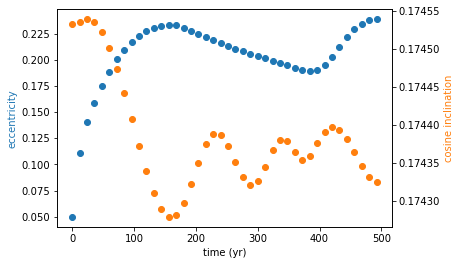

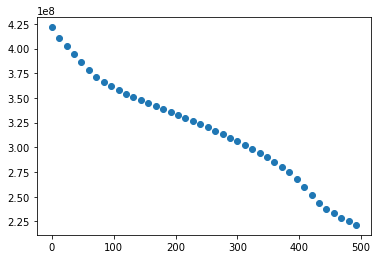

In [68]:
fig, ax = plt.subplots()
ax.scatter(times.value_in(units.yr),eccentricity)
ax.set_xlabel('time (yr)')
ax.set_ylabel('eccentricity',color='tab:blue')

ax2 = ax.twinx()
ax2.scatter(times.value_in(units.yr),incl_array,color='tab:orange')
ax2.set_ylabel('cosine inclination',color='tab:orange')


plt.show()

plt.figure()
plt.scatter(times.value_in(units.yr),semimajor_axis)